- At a minimum, the arguments we provide to `nn.Conv2d` are the number of **input features (or channels**, since we're dealing with multichannel images: that is, **more than one value per pixel**), the number of output features, and the size of the kernel.
- The more channels in the output image, the more the capacity of the network.
    - We need the channels to be able to detect many different types of features.
    - Also, because we are randomly initializing them, **some of the features we'll get, even after training, will turn out to be useless**. 
- **It is very common to have kernel sizes** that are **the same in all directions**. なので、3x3, 3x3x3. でも各方向のサイズが違っても可能。

In [4]:
import torch.nn as nn
import torch
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import torch.optim as optim
from PIL import Image

In [2]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

- Weight tensorのサイズ：`out_ch x in_ch x 3 x 3`.
- biasのサイズは`out_ch`になりそう：it's a constant value we add to **each channel of the output image**:

In [3]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

- もう一度cifar2を用意する：

In [6]:
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))
                          ]))
cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                       (0.2470, 0.2435, 0.2616))
                              ]))
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
         for img, label in cifar10
         if label in [0, 2]]
cifar2_val = [(img, label_map[label])
             for img, label in cifar10_val
             if label in [0, 2]]

- As usual, we need to add the zeroth batch dimension with `unsqueeze` if we want to call the `conv` module with one input image, since `nn.Conv2d` expects a `B x C x H x W` shaped tensor as input:

In [7]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

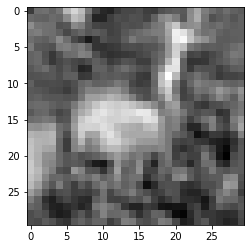

In [8]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

- detach()の意味：numpy ndarrayに変換する前にcomputation graphを消す。

### 8.2.1 Padding the boundary

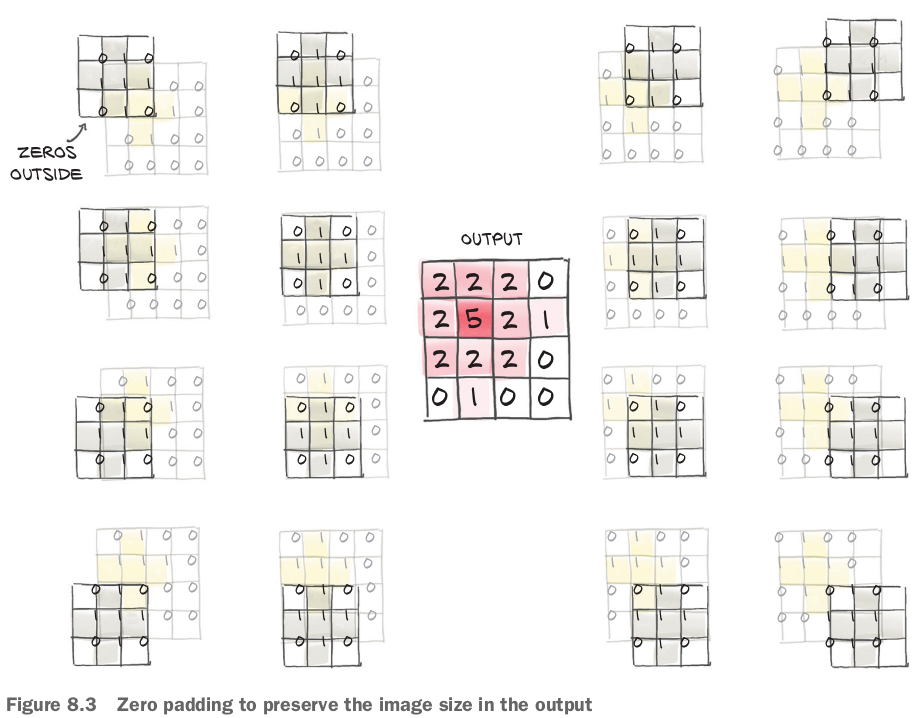

In [9]:
Image.open('img/padding-2020-12-28-11-15-02.png')

- For **even-sized kernels**, we would need to **pad by a different number on the left and right (and top and bottom)**.
    - PyTorch doesn't offer to do this in the convolution itself, but the function `torch.nn.functional.pad` can take care of it.
    - But it's **best to stay with odd kernel sizes; even-sized kernels are just odd**.

In [10]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

- pad convolutionsの２つ理由：
    - Doing so helps us separate the matters of convolution and changing image sizes, so we have one less thing to remember.
    - When we have more elaborate structures such as **skip connections or the U-Nets**, we want the tensors before and after a few convolutions to be of compatible size so that we can add them or take differences.

### 8.2.2 Detecting features with convolutions

In [11]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

- input画像は上にある。

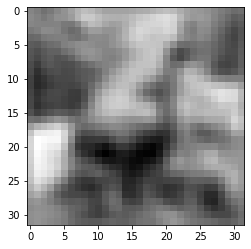

In [12]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

- The filter produces a blurred version of the image.
- After all, every pixel of the output is the average of a neighborhood of the input, so **pixels in the output are correlated and change more smoothly**. Mean Filterでしょう。

In [13]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                  [-1.0, 0.0, 1.0],
                                  [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

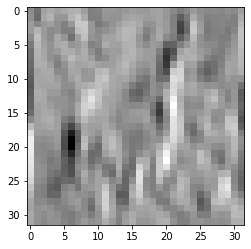

In [14]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

- In fact, the job of a computer vision expert has historically been to come up with the most effective combination of filters so that certain features are highlighted in images and objects can be recognized.

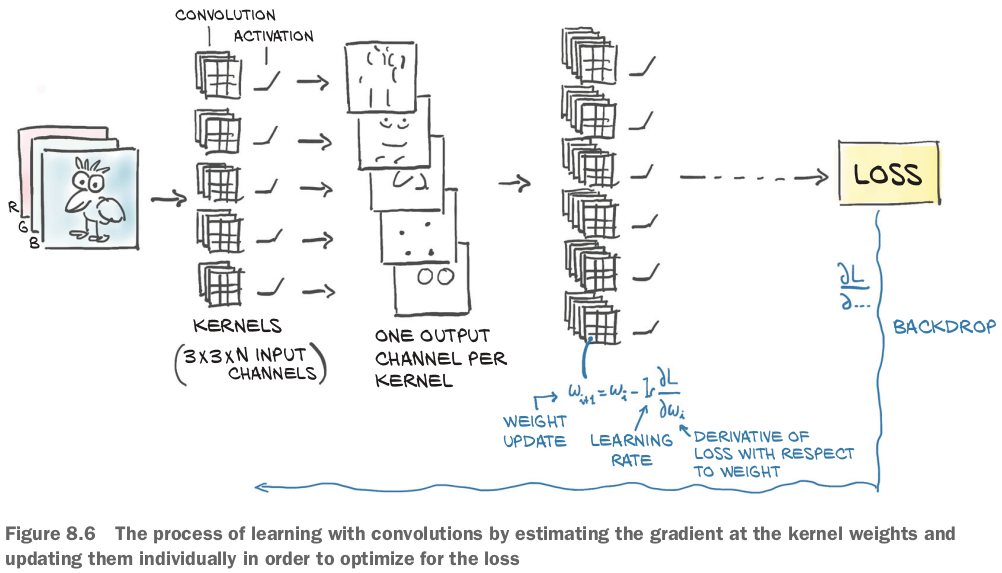

In [15]:
Image.open('img/learning-with-convolutions-2020-12-28-18-19-58.png')

### 8.2.3 Looking further with depth and pooling
- What about the big picture?
    - How do we know that all structures in our images are 3 pixels or 5 pixels wide?
    - Well, we don't, because they aren't.
    - And if they aren't, how are our networks going to be equipped to see those patterns with larger scope?
- 解決策：stacking one convolution after the other and at the same time downsampling the image between successive convolutions.
- downsamplingの選択肢（例えば2x2→1x1の場合）：
    - Average the 4 pixels.
        - This average pooling was a common approach early on but **has fallen out of favor somewhat**.
    - Max pooling, is currently the most commonly used approach, but it has a downside of discarding the other tree-quarters of the data.
    - Perform a **strided convolution**, where only every *N*th pixel is calculated.
        - The literature shows promise for this approach, but it has not yet supplanted ((策略または強引な手段で)取って代わる) max pooling. 確かにstrideが１の場合は多いのだ。

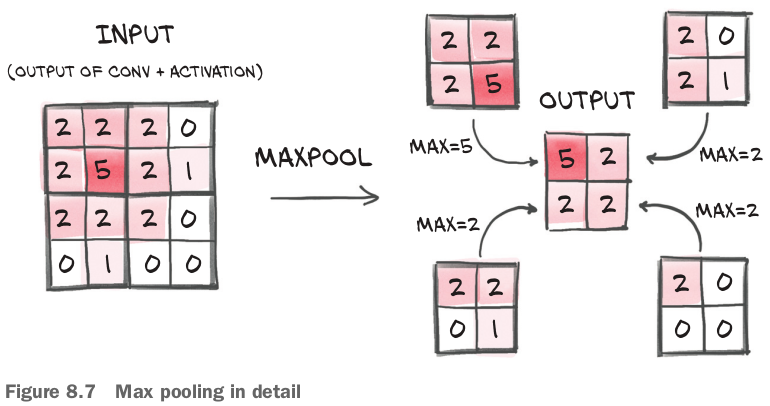

In [16]:
Image.open('img/max-pooling-2020-12-29-11-23-33.png')

- The figure shows the most common setup of taking **non-overlapping** 2x2 tiles and taking the maximum over each of them as the new pixel at the reduced scale.

In [18]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

- How combining convolutions and downsampling can help us recognize larger structures:

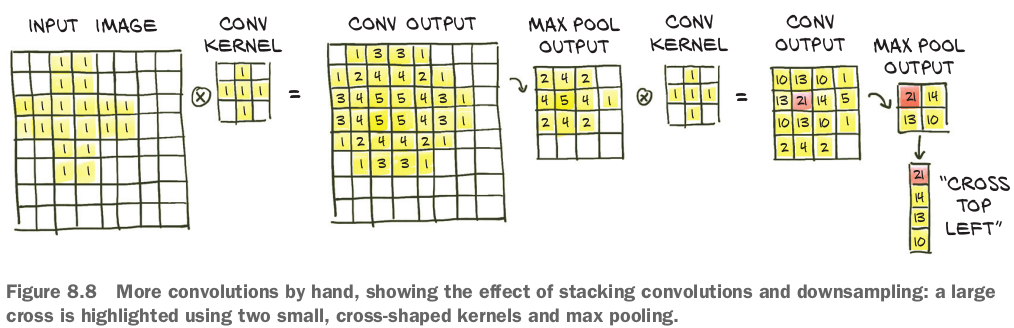

In [19]:
Image.open('img/large-cross-highlighted-with-two-samll-cross-kernel-and-max-pooling-2020-12-29-11-39-44.png')

- The first set of kernels operates on small neighborhoods on first-order low-level features, while the second set of kernels effectively operates on wider neighborhoods, producing features that are compositions of the previous features.
    - This is a very powerful mechanism that provides convolutional neural networks with the **ability to see into very complex scenes**.
    
### 8.2.4 Putting it all together for our network

In [ ]:
model = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, padding=1),
                      nn.Tanh(),
                      nn.MaxPool2d(2),
                      nn.Conv2d(16, 8, kernel_size=3, padding=1),
                      nn.Tanh(),
                      nn.MaxPool2d(2),
                      # ...
                     )

- After the input image has been reduced to a set of 8x8 features, we expect to be able to output some probabilities from the network that we can feed to our negative log likelihood.
    - However, probabilities are a pair of numbers in a 1D vector (one for airplane, one for bird), but here we're still dealing with multichannel 2D features.
- Turn the 8-channel 8x8 image into a 1D vector and complete our network with a set of fully connected layers:

In [21]:
model = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, padding=1),
                      nn.Tanh(),
                      nn.MaxPool2d(2),
                      nn.Conv2d(16, 8, kernel_size=3, padding=1),
                      nn.Tanh(),
                      nn.MaxPool2d(2),
                      # ... Warning: Something important is missing here! 展開してないこと？reshaping step.
                      nn.Linear(8 * 8 * 8, 32),
                      nn.Tanh(),
                      nn.Linear(32, 2))

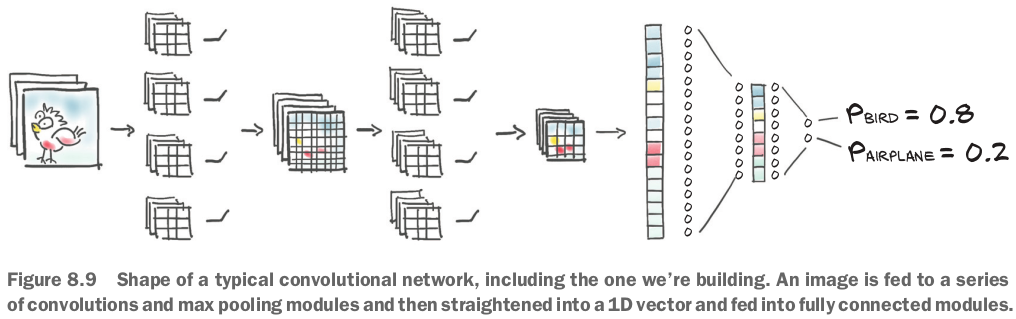

In [20]:
Image.open('img/typical-convolutional-network-2020-12-29-12-06-54.png')

In [22]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [23]:
model(img.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

- What's missing there is the **reshaping step** from an 8-channel 8x8 image to a 512-element, 1D vector.
- This could be achieved by calling `view` on the output of the last `nn.MaxPool2d`, but unfortunately, we don't have any explicit visibility of the output of each module when we use `nn.Sequential`. kerasのFlatten layerでしょう。
    - Not being able to do this kind of operation inside of `nn.Sequential` was an explicit design choice by the PyTorch authors and was left that way for a long time. この`view`を使いたい場合は、`forward`にやろうと進められている。正直kerasに`forward`のような素晴らしいものだけなさそう！
    - https://github.com/pytorch/pytorch/issues/2486
    - Recently, PyTorch gained an `nn.Flatten` layer.
    
## 8.3 Subclassing nn.Module
- At some point in developing neural networks, we will **find ourselves in a situation where we want to compute something that the premade modules do not cover**.
- How to make our own `nn.Module` subclasses that we can then use just like the prebuilt ones or `nn.Sequential`.
- **In order to subclass `nn.Module`, at a minimum we need to define a `forward` function that takes the inputs to the module and returns the output**.
- The name `forward` here is reminiscent(彷彿「ほうふつ」とさせる) of **a distant past, when modules needed to define both the forward and backward passes**.
- With PyTorch, if we use standard `torch` operations, **autograd will take care of the backward pass automatically**; and indeed, **an `nn.Module` never comes with a `backward`**.
- To include these `submodules`, we typically define them in the constructor `__init__` and assign them to `self` for use in the `forward` function.

### 8.3.1 Out network as an nn.Module

In [24]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

- 上記の構造にchannel数がw/hと一緒に減っているが、in many poular architectures like the ResNets, the reduction is achieved by pooling in the spatial resolution, but the number of channels increases (still resulting in a reduction in size).
    - It seems that our pattern of fast information reduction works well with networks of limited depth and small images; but **for deeper networks, the decrease is typically slower**.
- The first layer is exceptional in that it greatly increases the overall dimension (as in channels times pixels) of the data flowing through it, but **the mapping for each output pixel considered in isolation still has approximately as many outputs as inputs**.
    - 例えば、In ResNet, the initial convolution generates 64 channels from 147 elements (3 channels x 7 x 7 kernel size).

### 8.3.2 How PyTorch keeps track of parameters and submodules
- Interestingly, assigning an instance of `nn.Module` to an attribute (つまりself.xxx) in an `nn.Module` automatically registers the module as a submodule.
- We can call arbitrary methods of an `nn.Module` subclass.
    - For example, for a model where **training is substantially different than its use, say, for prediction**, it may make sense to have a `predict` method.

In [25]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

- **It appears a bit of a waste that we are also registering submodules that have no parameters**, like `nn.Tanh` and `nn.MaxPool2d`.
- **Wouldn't it be easier to call these directly in the `forward` function**, just as we called `view`?

### 8.3.3 The functional API
- That's why **PyTorch has *functional* counterparts for every `nn` module**.
- **By "functional" here we mean "having no internal state"** - in other words, "whose **output value is solely and fully determined by the value input arguments**."
- But instead of working on the input arguments and stored parameters like the module counterparts, they **take inputs and paramters as arguments** to the function call.
    - For instance, the functional counterpart of `nn.Linear` is `nn.functional.linear`, which is a function that has signature **`linear(input, weight, bias=None)`**.
- We can safely switch to the functional counterparts of pooling and activation, since they have no parameters(この点はきっとkerasより素晴らしいもう1点！):

In [26]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

- While general-purpose scientific functions like `tanh` still exist in `torch.nn.functional` in version 1.0, those entry points are deprecated in favor of functions in the top-level `torch` namespace.
- If we aim to quantize our model, it might be worthwhile to stick with the modular API if we go for non-JITed quantization.
    - 理由：quantizationの場合、stateless bits like activations suddenly become stateful because information about the quantization needs to be captured.

In [27]:
model = Net()
model(img.unsqueeze(0))

tensor([[0.1612, 0.1299]], grad_fn=<AddmmBackward>)

## 8.4 Training our convnet

In [28]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
            datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [29]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs=100,
             optimizer=optimizer,
             model=model,
             loss_fn=loss_fn,
             train_loader=train_loader,)

2020-12-29 16:17:03.581044 Epoch 1, Training loss 0.5945968320415278
2020-12-29 16:17:11.848477 Epoch 10, Training loss 0.3330611827646851
2020-12-29 16:17:21.119008 Epoch 20, Training loss 0.296368574925289
2020-12-29 16:17:29.722567 Epoch 30, Training loss 0.27234410314233437
2020-12-29 16:17:39.080499 Epoch 40, Training loss 0.253104515895722
2020-12-29 16:17:47.579828 Epoch 50, Training loss 0.23382850826545887
2020-12-29 16:17:57.448490 Epoch 60, Training loss 0.2204705422661107
2020-12-29 16:18:05.992679 Epoch 70, Training loss 0.20655517322812111
2020-12-29 16:18:14.523366 Epoch 80, Training loss 0.19060303327763917
2020-12-29 16:18:24.010286 Epoch 90, Training loss 0.17622023998836803
2020-12-29 16:18:33.522266 Epoch 100, Training loss 0.16205937754671285


### 8.4.1 Measuring accuracy
- In order to have a measure that is more **interpretable** than the loss, we can take a look at our accuracies on the training and validation datasets:

In [30]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        
        print("Accuracy {}: {:.2f}".format(name, correct / total))

validate(model, train_loader=train_loader, val_loader=val_loader)

Accuracy train: 0.94
Accuracy val: 0.90


- We cast to a Python `int` - **for integer tensors, this is equivalent to using `.item()`**, similar to what we did in the training loop.

### 8.4.2 Saving and loading our model
- **Since we're satisfied with our model so far, it would be nice to actually save it, right?**

In [32]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

- **No structure - just the weights**.
- This means when we deploy the model in production, we'll need to keep the `model` class handy, create an instance, and then load the parameters back into it:

In [33]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

### 8.4.3 Training on the GPU
- Using the `.to` method, we can move the tensors we get from the data loader to the GPU, after which our computation will automatically take place there.
- Happily, `nn.Module` implements a `.to` function that moves all of its parameters to the GPU.
- `Module.to`や`Tensor.to`の違い：
    - **`Module.to` is in place: the module instance is modified**.
    - But `Tensor.to` is out of place, returning a new tensor.
- **It is considered good style to move things to the GPU if one is available**.
    - **A good pattern is to set a variable `device` depending on `torch.cuda.is_available`**:

In [34]:
device = (torch.device('cuda') if torch.cuda.is_available()
         else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


- The code is exactly like our first version except for the two lines moving the inputs to the GPU:

In [37]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
            datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [38]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs=100,
             optimizer=optimizer,
             model=model,
             loss_fn=loss_fn,
             train_loader=train_loader,)

2020-12-29 17:32:11.505704 Epoch 1, Training loss 0.5793784234174497
2020-12-29 17:32:13.826863 Epoch 10, Training loss 0.33468344769660074
2020-12-29 17:32:16.358807 Epoch 20, Training loss 0.29744688037094796
2020-12-29 17:32:18.859992 Epoch 30, Training loss 0.2738522552191072
2020-12-29 17:32:21.375731 Epoch 40, Training loss 0.25273540691964946
2020-12-29 17:32:23.874457 Epoch 50, Training loss 0.23404877006438127
2020-12-29 17:32:26.375546 Epoch 60, Training loss 0.21912525143403155
2020-12-29 17:32:28.923220 Epoch 70, Training loss 0.20491570319719377
2020-12-29 17:32:31.460457 Epoch 80, Training loss 0.18978610359559392
2020-12-29 17:32:34.126372 Epoch 90, Training loss 0.17418435078327824
2020-12-29 17:32:36.713951 Epoch 100, Training loss 0.15977308071058266


- 3秒1epochになっている。さっきは8-10秒。
- modelをloadするとき、deviceを指定する：

In [39]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt',
                                       map_location=device))

<All keys matched successfully>